## Make Mie Tables

This is a short tutorial on generating Mie properties for monodisperse sizes using at3d.

In [1]:
#imports

import at3d
import numpy as np
import xarray as xr

### Making the Table

at3d objects and methods typically are documented.

In [2]:

help(at3d.mie.get_mono_table)

Help on function get_mono_table in module at3d.mie:

get_mono_table(particle_type, wavelength_band, minimum_effective_radius=4.0, max_integration_radius=65.0, wavelength_averaging=False, wavelength_resolution=0.001, refractive_index=None, relative_dir=None, verbose=True)
    Mie monodisperse scattering for spherical particles.
    This function will search a given directory to load the requested mie table or will compute it.
    The table is returned as an xr Dataset.
    
    Parameters
    ----------
    particle_type: string
        Options are 'Water' or 'Aerosol'.
    wavelength_band: (float, float)
        (minimum, maximum) wavelength in microns.
        This defines the spectral band over which to integrate, if both are equal
        monochrome quantities are computed.
    minimum_effective_radius: float
        Minimum effective radius in microns. Used to compute minimum radius for integration.
    max_integration_radius: float
        Maximum radius in microns - cutoff for th

In [3]:
%%time
mie_mono_table = at3d.mie.get_mono_table(
    'Water',(0.86,0.86),
    max_integration_radius=65.0,
    minimum_effective_radius=0.1,
    relative_dir='../mie_tables',
    verbose=False
)
# verbose prints to standard out which is in the notebook terminal.

CPU times: user 14.6 s, sys: 64.4 ms, total: 14.7 s
Wall time: 14.7 s


`get_mono_table` will first search a directory to see if the requested table exists
otherwise it will calculate it. You can save it to see if it works.

In [4]:
mie_mono_table.to_netcdf('../mie_tables/test.nc')
mie_mono2 = at3d.mie.get_mono_table(
    'Water',(0.86,0.86),
    max_integration_radius=65.0,
    minimum_effective_radius=0.1,
    relative_dir='../mie_tables',
    verbose=False
)
print(mie_mono_table.equals(mie_mono2))

True


### Using the Table

The contents of mie_mono_table can be easily viewed with xarray's interface.
The attributes record the inputs used to generate this table.

To calculate optical properties typically you would integrate over a range of sizes. at3d has
tools for that in the at3d.size_distribution and at3d.medium modules that take
datasets of the same format as `mie_mono_table` as input.

SHDOM uses a Legendre/Wigner expansion of the phase functions rather than tabulated phase functions which 
are more common for MonteCarlo methods.


In [5]:
mie_mono_table

<xarray.Dataset>
Dimensions:       (radius: 1444, stokes_index: 6, legendre_index: 1017)
Coordinates:
  * radius        (radius) float32 0.002 0.003369 0.004737 ... 64.88 64.97 65.06
  * stokes_index  (stokes_index) <U3 'P11' 'P22' 'P33' 'P44' 'P12' 'P34'
Dimensions without coordinates: legendre_index
Data variables:
    extinction    (radius) float32 1.83e-13 2.023e-12 ... 2.686e+04 2.706e+04
    scatter       (radius) float32 6.358e-14 1.452e-12 ... 2.686e+04 2.706e+04
    nleg          (radius) int32 4 6 6 6 6 6 6 ... 1010 1010 1012 1014 1014 1016
    legendre      (stokes_index, legendre_index, radius) float32 6.358e-14 .....
Attributes:
    particle_type:               Water
    refractive_index:            (1.3300000429153442, -2.893244186452648e-07)
    refractive_index_source:     src/polarized/indexwatice.f
    units:                       ['Radius [micron]', 'Wavelength [micron]']
    wavelength_band:             (0.86, 0.86)
    wavelength_center:           0.8600000143051147
    wavelength_averaging:        False
    wavelength_resolution:       0.001
    maximum_legendre:            1016
    minimum_effective_radius:    0.1
    maximum_integration_radius:  65.0

### Visualization

`xarray`'s inbuilt plotting methods can be used and utility functions are available for evaluating the phase function at different scattering angles for visualization purposes.
Note that we can evaluate the phase function for all of the radii or only some.

In [6]:


phase_function = at3d.util.get_phase_function(mie_mono_table.legendre[...,400], np.linspace(0.0,180.0,360), phase_elements='All')

In [7]:
phase_function

<xarray.DataArray 'phase_function' (phase_elements: 6, scattering_angle: 360)>
array([[ 1.5370811e+05,  1.4899702e+05,  1.3557556e+05, ...,
         3.1050247e+02,  3.6706357e+02,  3.8812970e+02],
       [ 1.5370811e+05,  1.4899702e+05,  1.3557556e+05, ...,
         3.1050146e+02,  3.6706250e+02,  3.8812860e+02],
       [ 1.5370811e+05,  1.4899683e+05,  1.3557267e+05, ...,
        -3.0722113e+02, -3.6684412e+02, -3.8812860e+02],
       [ 1.5370811e+05,  1.4899683e+05,  1.3557267e+05, ...,
        -3.0722211e+02, -3.6684515e+02, -3.8812964e+02],
       [ 0.0000000e+00,  1.5793364e+02,  5.8583807e+02, ...,
        -1.4455037e+01, -3.9030981e+00,  0.0000000e+00],
       [ 0.0000000e+00, -1.7936165e+02, -6.6234692e+02, ...,
        -4.2631008e+01, -1.2042716e+01,  0.0000000e+00]], dtype=float32)
Coordinates:
  * phase_elements    (phase_elements) <U3 'P11' 'P22' 'P33' 'P44' 'P12' 'P34'
  * scattering_angle  (scattering_angle) float64 0.0 0.5014 ... 179.5 180.0
    radius            float32 5.205

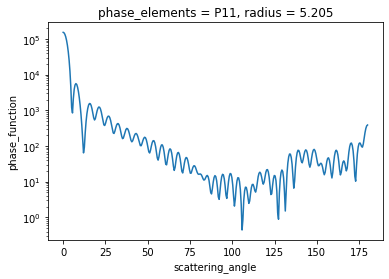

In [8]:
phase_function[0].plot(yscale='log')